In [1]:
import seaborn as sns
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
import glob
import pandas as pd
import os
import random
from datetime import datetime
from torch.optim.lr_scheduler import StepLR
from Input_Cell_Attention.Scripts.cell import *
from torch.utils.tensorboard import SummaryWriter
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
from train_concept import generate_dataset,Concept_model
from train_theta import fix_theta
from train_attention import Attention_model
from train_cell import LSTM_Input_Cell
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
PADDING_DATASET = True
NORMALIZATION_OUTPUT = True
DRAW_DISTRIBUTION = False
USE_BEST_MODEL = True
train_data,test_data,evaluate_data,train_label,test_label, evaluate_label = generate_dataset()
hiddne_size = 8
epsilon = 1e-4
gamma = 0.2
decay_step = 50
train_num = 2000
test_num = 100
evaluate_num = 100
train_data,test_data,evaluate_data,train_label,test_label, evaluate_label = generate_dataset()

In [3]:
device = torch.device("cuda")
net = torch.load("./model_save/cell.pth")

In [9]:
def minmaxscaler_saliency(grad):
    min = np.amin(grad)
    max = np.amax(grad)    
    return (grad - min)/(max-min)

def concept_map(model,index,test_data):
    model.zero_grad()
    x = torch.unsqueeze(test_data[index], axis=0).to(device)
    output,theta = model(x,output_explain=True)
    grad = theta.detach().cpu().numpy()[0]
    return grad, np.abs(grad)

def theta_map(model):
    weight = model.fc3.weight[0].detach().cpu().numpy()
    return weight, np.abs(weight)

def attention_map(model,index,test_data):
    model.eval()
    x = torch.unsqueeze(test_data[index], axis=0).to(device)
    output,attention = model(x,output_explain=True)
    attention = attention.detach().cpu().numpy()
    return attention.squeeze(),np.abs(attention).squeeze()

def saliency_map(net, index, test_data):
    # with torch.backends.cudnn.flags(enabled=False):
    x = torch.unsqueeze(test_data[index], axis=0).to(device)
    net.zero_grad()
    input1 = net.emd1(x[:,:,0])
    input2 = net.emd2(x[:,:,1])
    input3 = net.emd3(x[:,:,2])
    input4 = net.emd4(x[:,:,3])
    input5 = net.emd5(x[:,:,4])
    input6 = net.emd6(x[:,:,5])
    input7 = net.emd7(x[:,:,6])
    input8 = net.emd8(x[:,:,7])
    feed_ = torch.cat((input1, input2), axis=2)
    feed_ = torch.cat((feed_, input3), axis=2)
    feed_ = torch.cat((feed_, input4), axis=2)
    feed_ = torch.cat((feed_, input5), axis=2)
    feed_ = torch.cat((feed_, input6), axis=2)
    feed_ = torch.cat((feed_, input7), axis=2)
    feed_ = torch.cat((feed_, input8), axis=2)
    feed_.retain_grad()
    h0 = torch.zeros(1, feed_.size(0), net.h_size).to(device)
    c0 = torch.zeros(1, feed_.size(0), net.h_size).to(device)
    out, (h_n, h_c) = net.lstm(feed_, (h0, c0))
    feed = net.fc1(out[:, -1, :])
    feed = F.sigmoid(feed)
    # feed = net.dropout1(feed)
    feed = net.fc2(feed)
    feed = F.sigmoid(feed)
    feed = net.fc3(feed)
    feed = F.sigmoid(feed)
    feed = net.fc4(feed)
    feed.backward()
    grad = feed_.grad.data.cpu().numpy().squeeze()
    abs_grad = np.abs(grad)
    return grad, abs_grad

def integrated_grad(net, index, test_data,steps,baseline):
    # with torch.backends.cudnn.flags(enabled=False):
    x = torch.unsqueeze(test_data[index], axis=0).to(device)
    net.zero_grad()
    input1 = net.emd1(x[:,:,0])
    input2 = net.emd2(x[:,:,1])
    input3 = net.emd3(x[:,:,2])
    input4 = net.emd4(x[:,:,3])
    input5 = net.emd5(x[:,:,4])
    input6 = net.emd6(x[:,:,5])
    input7 = net.emd7(x[:,:,6])
    input8 = net.emd8(x[:,:,7])
    feed_ = torch.cat((input1, input2), axis=2)
    feed_ = torch.cat((feed_, input3), axis=2)
    feed_ = torch.cat((feed_, input4), axis=2)
    feed_ = torch.cat((feed_, input5), axis=2)
    feed_ = torch.cat((feed_, input6), axis=2)
    feed_ = torch.cat((feed_, input7), axis=2)
    feed_ = torch.cat((feed_, input8), axis=2)
    if baseline is None:
        baseline = 0 * feed_
    else:
        baseline = baseline * feed_
    inputs = [baseline + (float(i) / steps) * (feed_ - baseline) for i in range(0, steps + 1)]
    grads = []
    for scaled_inputs in inputs:
        scaled_inputs.requires_grad_()
        scaled_inputs.retain_grad()
        h0 = torch.zeros(1, scaled_inputs.size(0), net.h_size).to(device)
        c0 = torch.zeros(1, scaled_inputs.size(0), net.h_size).to(device)
        out, (h_n, h_c) = net.lstm(scaled_inputs, (h0, c0))
        feed = net.fc1(out[:, -1, :])
        feed = F.sigmoid(feed)
        # feed = net.dropout1(feed)
        feed = net.fc2(feed)
        feed = F.sigmoid(feed)
        feed = net.fc3(feed)
        feed = F.sigmoid(feed)
        feed = net.fc4(feed)
        net.zero_grad()
        feed.backward(retain_graph=True)
        gradients = scaled_inputs.grad.data.cpu().numpy()[0]
        grads.append(gradients)
    grads = np.array(grads)
    # print(grads.shape)
    avg_grads = np.average(grads[:-1], axis=0)
    delta_X = (feed_ - baseline).detach().squeeze(0).cpu().numpy()
    integrated_grad = delta_X * avg_grads
    abs_grad = np.abs(integrated_grad)
    return integrated_grad, abs_grad

def random_baseline_integrated_gradients(net, index, test_data,steps,num_random_trials):
    all_intgrads = []
    for i in range(num_random_trials):
        grad = integrated_grad(net, index, test_data,steps,baseline = random.random())
        all_intgrads.append(grad)
    
    avg_intgrads = np.average(np.array(all_intgrads),axis=0)
    return avg_intgrads

def smoothgrad(net, index, test_data, n_samples = 25, stdev_spread=0.05):
    # with torch.backends.cudnn.flags(enabled=False):
    x = torch.unsqueeze(test_data[index], axis=0).to(device)
    net.zero_grad()
    input1 = net.emd1(x[:,:,0])
    input2 = net.emd2(x[:,:,1])
    input3 = net.emd3(x[:,:,2])
    input4 = net.emd4(x[:,:,3])
    input5 = net.emd5(x[:,:,4])
    input6 = net.emd6(x[:,:,5])
    input7 = net.emd7(x[:,:,6])
    input8 = net.emd8(x[:,:,7])
    feed_ = torch.cat((input1, input2), axis=2)
    feed_ = torch.cat((feed_, input3), axis=2)
    feed_ = torch.cat((feed_, input4), axis=2)
    feed_ = torch.cat((feed_, input5), axis=2)
    feed_ = torch.cat((feed_, input6), axis=2)
    feed_ = torch.cat((feed_, input7), axis=2)
    feed_ = torch.cat((feed_, input8), axis=2)
    total_grad = []
    stdev = stdev_spread * (torch.max(feed_) - torch.min(feed_))
    for i in range(n_samples):
        noise = torch.normal(torch.zeros(feed_.shape).to(device),stdev)
        feed_noise = feed_ + noise
        feed_noise.retain_grad()
        h0 = torch.zeros(1, feed_noise.size(0), net.h_size).to(device)
        c0 = torch.zeros(1, feed_noise.size(0), net.h_size).to(device)
        out, (h_n, h_c) = net.lstm(feed_noise, (h0, c0))
        feed = net.fc1(out[:, -1, :])
        feed = F.sigmoid(feed)
        # feed = net.dropout1(feed)
        feed = net.fc2(feed)
        feed = F.sigmoid(feed)
        feed = net.fc3(feed)
        feed = F.sigmoid(feed)
        feed = net.fc4(feed)
        feed.backward(retain_graph=True)
        grad = feed_noise.grad.data.cpu().numpy().squeeze()
        total_grad.append(grad)

    avg_intgrads = np.average(np.array(total_grad),axis=0)
    abs_grad = np.abs(avg_intgrads)
    return avg_intgrads, abs_grad

In [5]:
def write_summary(num, net, test_data, test_label, target_dir, method, grad_method,start,end):
    writer = open(target_dir,'w')
    for index in range(num):
        to_write = ""
        
        if grad_method == 'attention':
            grad, abs_grad = attention_map(net, index, test_data)
        if grad_method == 'theta':
            grad, abs_grad = theta_map(net)
        if grad_method == 'saliency':
            grad, abs_grad = saliency_map(net, index, test_data)
        if grad_method == 'concept':
            grad, abs_grad = concept_map(net, index, test_data)
        if grad_method == 'integrated':
            grad, abs_grad = integrated_grad(net, index, test_data,steps=30,baseline=None)
        if grad_method == 'smooth':
            grad, abs_grad = smoothgrad(net, index, test_data, n_samples = 25, stdev_spread=0.05)


        if method == 'a_mean':
            if grad_method == 'saliency' or grad_method == 'smooth' or grad_method == 'integrated':
                abs_grad = np.mean(abs_grad, axis=1)
            scale = minmaxscaler_saliency(abs_grad)[start:end]
 
        max_loc = np.argmax(scale)+start
        min_loc = np.argmin(scale)+start
        to_write += str(max_loc)+";"+str(min_loc)+'\n'
        writer.writelines(to_write)

In [10]:
# method = 'a_mean'
# num = 500
# grad_method = 'integrated'
# target_dir = 'summary_explain/' + grad_method + '.txt'
# start = 0
# end = 64
# write_summary(num,net,train_data,train_label,target_dir,method,grad_method,start,end)

In [ ]:
import numpy as np
average = []
for i in range(8):
    a = []
    for j in range(64):
        train_data_tmp = train_data[:,j,i]
        a.append(np.correlate(train_data_tmp.flatten(), train_label.flatten())[0])
    average.append(a)
average = np.array(average)
average = np.mean(average, axis=0)
print(average) 
print(np.argsort(average))

In [28]:
def plot_grad_distribution(index, net, test_data, test_label, method,grad_method):

    if grad_method == 'attention':
        grad, abs_grad = attention_map(net, index, test_data)
    if grad_method == 'theta':
        grad, abs_grad = theta_map(net)
    if grad_method == 'saliency':
        grad, abs_grad = saliency_map(net, index, test_data)
    if grad_method == 'concept':
        grad, abs_grad = concept_map(net, index, test_data)
    if grad_method == 'integrated':
        grad, abs_grad = integrated_grad(net, index, test_data,steps=5,baseline=None)
    if grad_method == 'smooth':
        grad, abs_grad = smoothgrad(net, index, test_data, n_samples=5, stdev_spread=0.05)
    if method == 'a_mean':
        # grad = np.abs(grad)
        # mean = np.mean(grad, axis=1)
        # scale = minmaxscaler_saliency(mean)
        if grad_method == 'saliency' or grad_method == 'smooth' or grad_method == 'integrated':
            abs_grad = np.mean(abs_grad, axis=1)
        mean_abs = abs_grad
        scale_abs = minmaxscaler_saliency(mean_abs)

    x = np.arange(0, 64)
    plt.figure(1)
    # ax1 = plt.subplot(2,1,1)
    # ax2 = plt.subplot(2,1,2)

    # plt.sca(ax1)
    # plt.plot(x,scale,label='scaled grad')
    # plt.ylabel('scaled grad')
    # plt.xlabel('state')
    # plt.legend()
    # plt.title("Scaled grad distribution")

    # plt.sca(ax2)
    plt.plot(x,scale_abs,label='abs scaled grad')
    plt.ylabel('abs scaled grad')
    plt.xlabel('state')
    plt.legend()
    plt.title("Grad distribution")
    plt.show()
    

/home/jvy5516/project/battle/Input_Cell_Attention/Scripts/cell.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_2d = F.softmax(input_2d)
/home/jvy5516/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


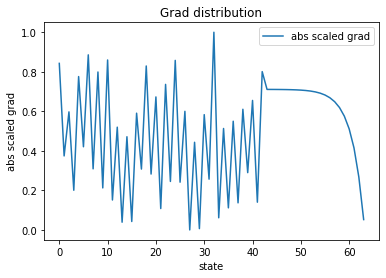

In [31]:
method = 'a_mean'
index = 2
grad_method = 'integrated'
device = torch.device("cuda")
net = torch.load("./model_save/cell.pth")
plot_grad_distribution(index,net, train_data,train_label,method, grad_method)

In [ ]:
method = 'a_mean'
index = 1
grad_method = 'concept'
plot_grad_distribution(index,net, train_data,train_label,method, grad_method)